In [1]:
import os
data_dir="/home/pranav/dataset"

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2025-06-09 18:23:46.139112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 18:23:46.373474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749493426.483962   71966 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749493426.510767   71966 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749493426.738711   71966 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.05,
    fill_mode='nearest'
)

#Loading training data
train_generator = data_generator.flow_from_directory(
    directory=data_dir + "/train",
    target_size=(28, 28),
    batch_size=32,
    class_mode="sparse",
)

#Load validation data
validation_generator = data_generator.flow_from_directory(
    directory=data_dir + "/val",
    target_size=(28, 28),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  #Ensure labels align with predictions
)
print(train_generator.class_indices)

Found 11520 images belonging to 36 classes.
Found 2880 images belonging to 36 classes.
{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_9': 9, 'class_A': 10, 'class_B': 11, 'class_C': 12, 'class_D': 13, 'class_E': 14, 'class_F': 15, 'class_G': 16, 'class_H': 17, 'class_I': 18, 'class_J': 19, 'class_K': 20, 'class_L': 21, 'class_M': 22, 'class_N': 23, 'class_O': 24, 'class_P': 25, 'class_Q': 26, 'class_R': 27, 'class_S': 28, 'class_T': 29, 'class_U': 30, 'class_V': 31, 'class_W': 32, 'class_X': 33, 'class_Y': 34, 'class_Z': 35}


In [4]:
#Get class index mapping
class_indices = validation_generator.class_indices

#Reverse the dictionary (this will get label index → character)
index_to_class = {v: k for k, v in class_indices.items()}

#Convert from folder names (class_A, class_B) to actual characters ('A', 'B')
index_to_char = {i: k.split("_")[-1] for i, k in index_to_class.items()}  #Extract last part after '_'

#Print the mapping
print(index_to_char)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [5]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int64)

        tp = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.not_equal(y_pred, y_true), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.not_equal(y_true, y_pred), tf.float32))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [6]:
K.clear_session()
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(36, activation='softmax')
])

#Compile Model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', F1Score()]
)
model.summary()

/home/pranav/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749493587.500618   71966 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,668 (1.52 MB)

 Trainable params: 397,668 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get("val_f1_score") > 0.99:
            print("\n Reached 99% Validation F1 Score, stopping training!!")
            self.model.stop_training = True

callbacks = [
    EarlyStoppingCallback(),
    tf.keras.callbacks.ModelCheckpoint('char_recog3.keras', save_best_only=True, monitor='val_f1_score', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/25


/home/pranav/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749493674.817547   75320 service.cc:152] XLA service 0x7eff3001ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749493674.817590   75320 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-09 18:27:54.871331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749493675.081282   75320 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-09 18:27:56.172760: I

  9/360 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.0357 - f1_score: 0.0357 - loss: 3.5933 

I0000 00:00:1749493678.847335   75320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.3637 - f1_score: 0.3637 - loss: 2.2635 - val_accuracy: 0.9031 - val_f1_score: 0.9031 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 2/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8577 - f1_score: 0.8577 - loss: 0.4139 - val_accuracy: 0.9490 - val_f1_score: 0.9490 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 3/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9049 - f1_score: 0.9049 - loss: 0.2616 - val_accuracy: 0.9615 - val_f1_score: 0.9615 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 4/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9300 - f1_score: 0.9300 - loss: 0.1894 - val_accuracy: 0.9604 - val_f1_score: 0.9604 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 5/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9414 - f1_score: 0.9414 - loss: 0.1564 - val_accuracy: 0.9656 - val_f1_score: 0.9656 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 6/25
360/360 ━━━━━━━━━━━━━━━━

In [10]:
from sklearn.metrics import classification_report

#Load the best model
best_model = tf.keras.models.load_model('char_recog3.keras', custom_objects={'F1Score': F1Score})

#Predict on validation data
Y_true = validation_generator.classes
Y_pred = best_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

#Generate Classification Report
print("Validation Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=list(validation_generator.class_indices.keys())))

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     class_0       0.78      0.81      0.80        80
     class_1       0.99      0.97      0.98        80
     class_2       1.00      1.00      1.00        80
     class_3       1.00      1.00      1.00        80
     class_4       1.00      1.00      1.00        80
     class_5       1.00      0.99      0.99        80
     class_6       1.00      0.97      0.99        80
     class_7       1.00      1.00      1.00        80
     class_8       0.99      1.00      0.99        80
     class_9       1.00      1.00      1.00        80
     class_A       1.00      1.00      1.00        80
     class_B       1.00      1.00      1.00        80
     class_C       1.00      1.00      1.00        80
     class_D       0.99      1.00      0.99        80
     class_E       1.00      1.00      1.00        80
     class_F       1.00      1.00      1.00        80
     cl

/home/pranav/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/home/pranav/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


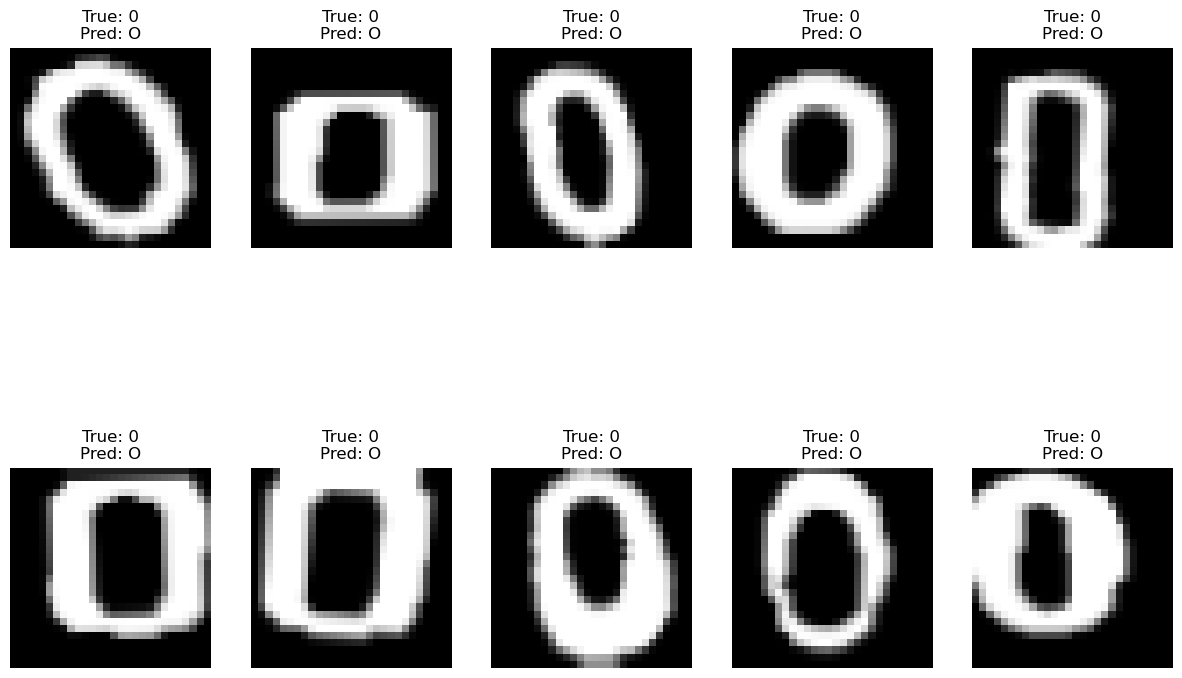

In [11]:
#Reset the validation generator to ensure consistent ordering
validation_generator.reset()

#Generate predictions for the validation set
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)  #Convert predictions to class indices

#Extract true labels from the validation generator
y_true = validation_generator.classes

#Find misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]

#Display some misclassified images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:10]):  #Shows first 10 misclassified images
    plt.subplot(2, 5, i + 1)
    img = validation_generator[idx // validation_generator.batch_size][0][idx % validation_generator.batch_size]
    plt.imshow(img)
    plt.title(f'True: {index_to_char[y_true[idx]]}\nPred: {index_to_char[y_pred[idx]]}')
    plt.axis('off')
plt.show()

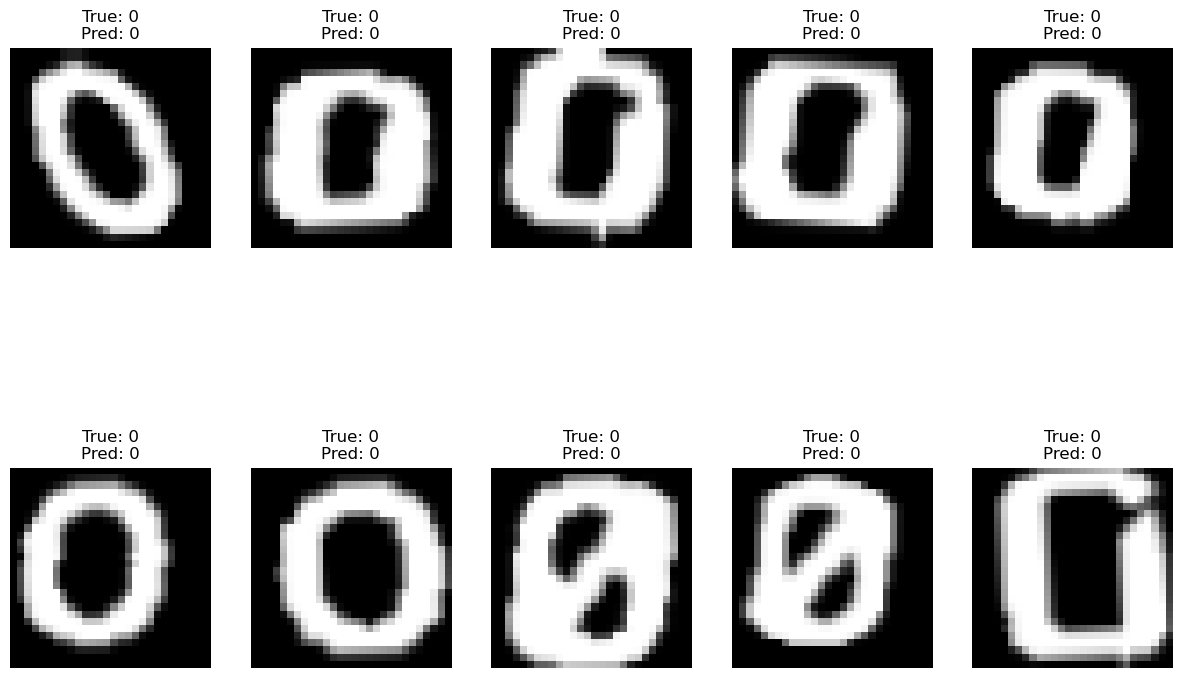

In [12]:
#Find correctly predicted samples
correctly_predicted_indices = np.where(y_pred == y_true)[0]

#Display some correctly predicted images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(correctly_predicted_indices[:10]):  #first 10 correctly predicted images
    plt.subplot(2, 5, i + 1)
    img = validation_generator[idx // validation_generator.batch_size][0][idx % validation_generator.batch_size]
    plt.imshow(img)
    plt.title(f'True: {index_to_char[y_true[idx]]}\nPred: {index_to_char[y_pred[idx]]}')
    plt.axis('off')
plt.show()

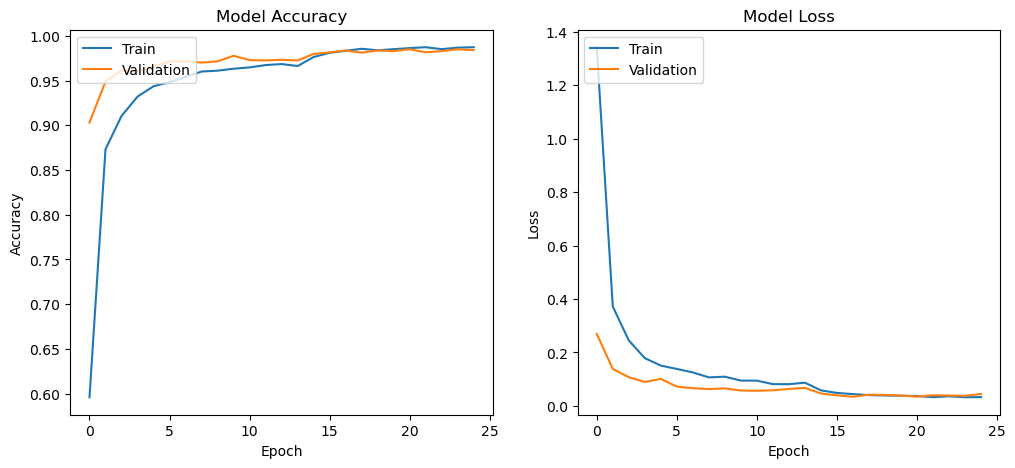

In [13]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Plot training vs validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Plot training vs validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


/home/pranav/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


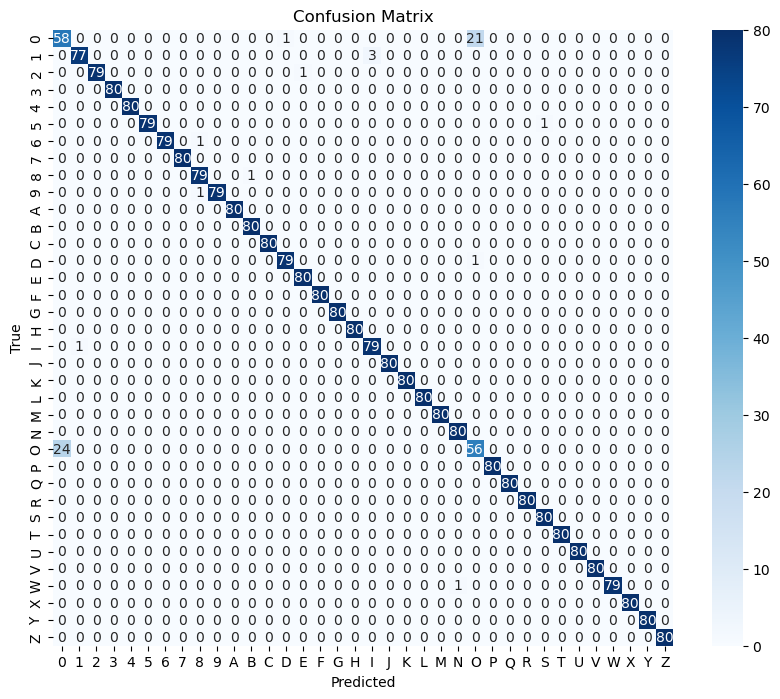

In [14]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_generator.reset()

#Generate predictions for the validation set
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)

#Extract true labels
y_true = validation_generator.classes

#Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=index_to_char.values(), yticklabels=index_to_char.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
sample_img_dir ="/home/pranav/Sample_Img"
image_files = [f for f in os.listdir(sample_img_dir) if f.endswith(('.jpg', '.JPG', '.png', '.PNG', '.wbep', '.WBEP'))]
print(f"Found {len(image_files)} images: {image_files}")

Found 24 images: ['CarPlate9.jpg', 'CarPlate18.jpg', 'CarPlate20.jpg', 'CarPlate10.jpg', 'CarPlate6.jpg', 'CarPlate17.jpg', 'CarPlate12.png', 'CarPlate3.jpg', 'CarPlate14.jpg', 'CarPlate15.jpg', 'CarPlate4.jpg', 'CarPlate.jpg', 'CarPlate24.jpg', 'CarPlate8.jpg', 'CarPlate2.jpg', 'CarPlate25.jpg', 'CarPlate7.jpg', 'CarPlate5.jpg', 'CarPlate16.jpg', 'CarPlate27.jpg', 'CarPlate28.jpg', 'CarPlate26.jpg', 'CarPlate19.jpg', 'CarPlate11.jpg']


Processing CarPlate9.jpg...
License Plate: GJO4EE6437


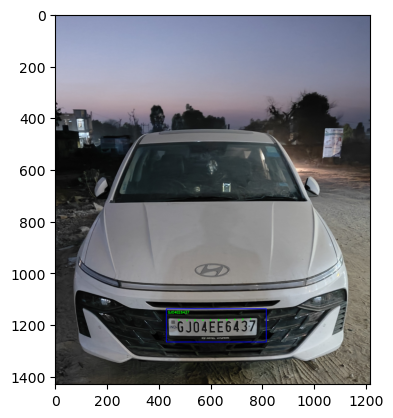

Processing CarPlate18.jpg...
License Plate: WBHR
License Plate: CI
License Plate: 
License Plate: TWKFE5S
License Plate: BOYSH0STEL
License Plate: Rajasthan 74UN4769
License Plate: 
License Plate: 


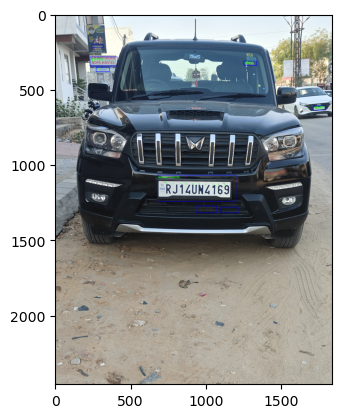

Processing CarPlate20.jpg...
License Plate: Rajasthan 45CR5105
License Plate: TSSU5
License Plate: A


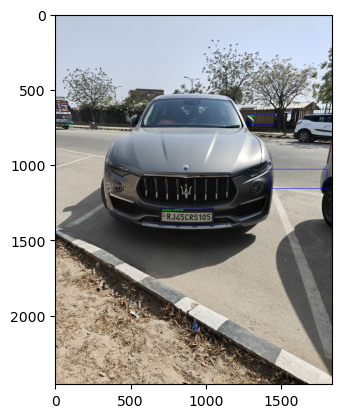

Processing CarPlate10.jpg...
License Plate: 
License Plate: 
License Plate: Uttar Pradesh 85BW1000


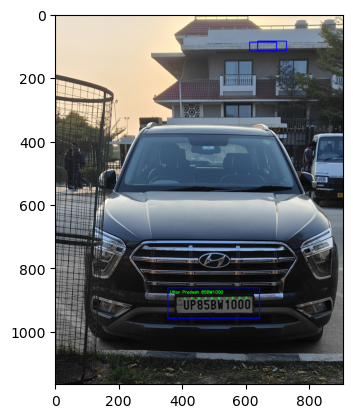

Processing CarPlate6.jpg...
License Plate: J
License Plate: Uttar Pradesh 6AD3736
License Plate: Uttar Pradesh 6AD3736
License Plate: 


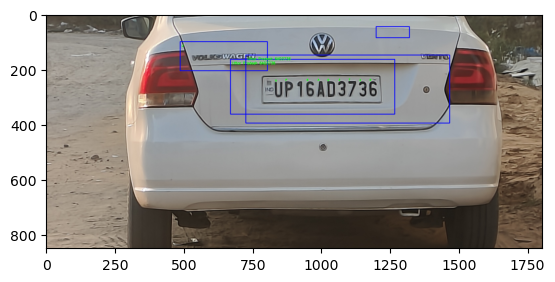

Processing CarPlate17.jpg...
License Plate: 
License Plate: 
License Plate: 1R1
License Plate: 
License Plate: 
License Plate: Delhi 1CE1602


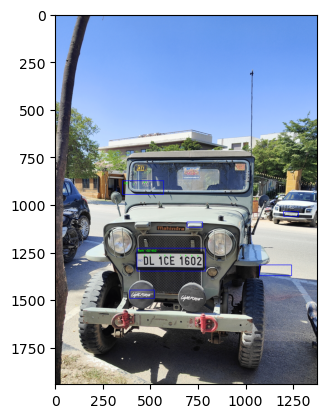

Processing CarPlate12.png...
License Plate: TG109999


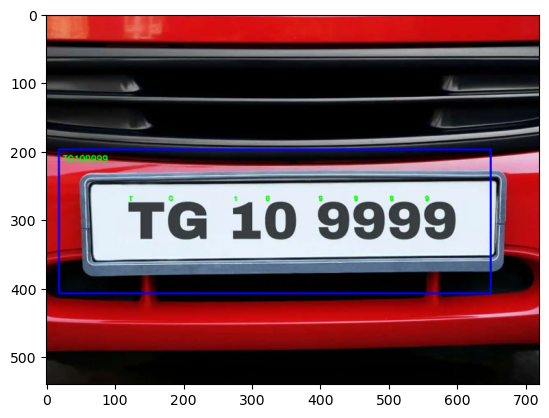

Processing CarPlate3.jpg...
License Plate: RIUW779
License Plate: 31QO
License Plate: IS
License Plate: R118ER1D
License Plate: 
License Plate: 
License Plate: 
License Plate: M
License Plate: Rajasthan 45CH0426


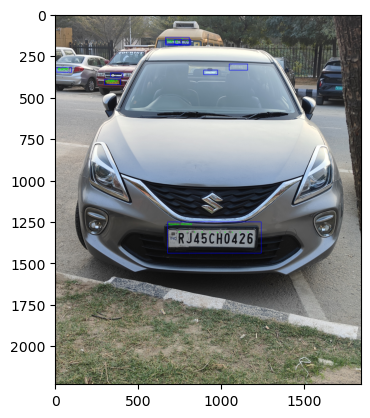

Processing CarPlate14.jpg...
License Plate: Rajasthan 792C7055
License Plate: BJU1UJ19


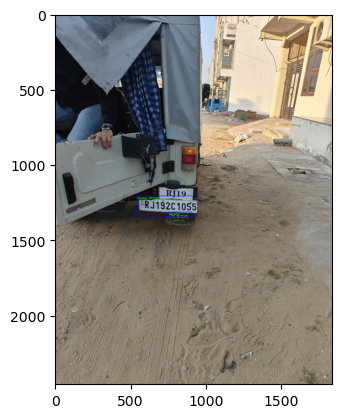

Processing CarPlate15.jpg...
License Plate: 
License Plate: Maharashtra 72BG7237


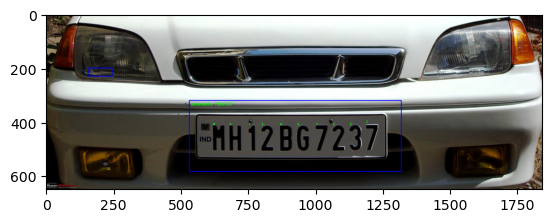

Processing CarPlate4.jpg...
License Plate: 
License Plate: T1UJ1
License Plate: ANHZ102


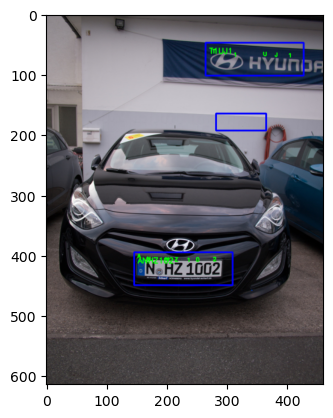

Processing CarPlate.jpg...
License Plate: CCC444


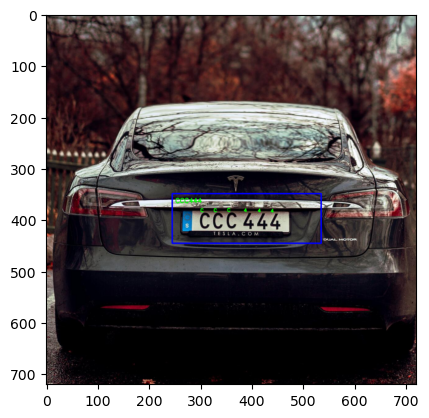

Processing CarPlate24.jpg...
License Plate: 020749


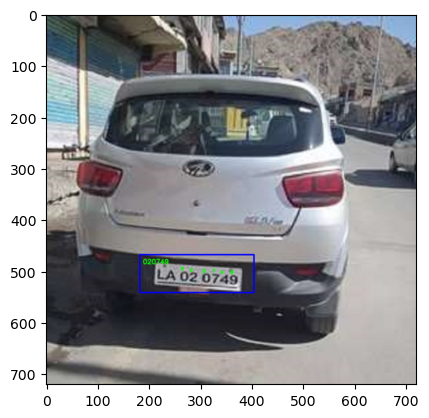

Processing CarPlate8.jpg...
License Plate: B
License Plate: GJO4EE6437


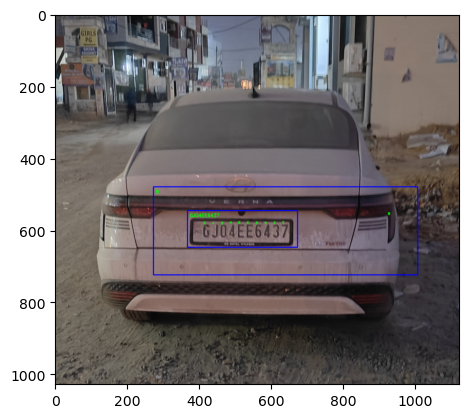

Processing CarPlate2.jpg...


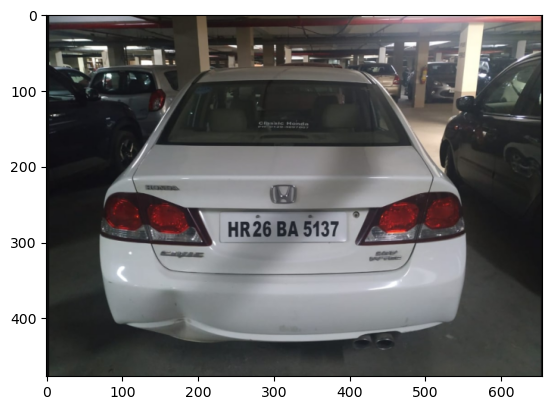

Processing CarPlate25.jpg...
License Plate: 
License Plate: 1DZ7
License Plate: KL02BM4659
License Plate: 
License Plate: KL02BM4659
License Plate: 
License Plate: 
License Plate: 
License Plate: 
License Plate: 
License Plate: 
License Plate: M
License Plate: J
License Plate: J


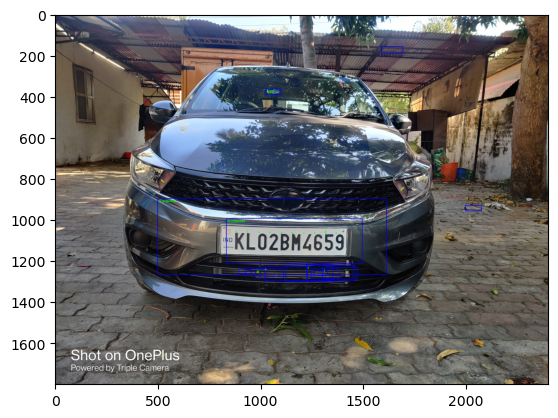

Processing CarPlate7.jpg...
License Plate: Rajasthan 74CF1399


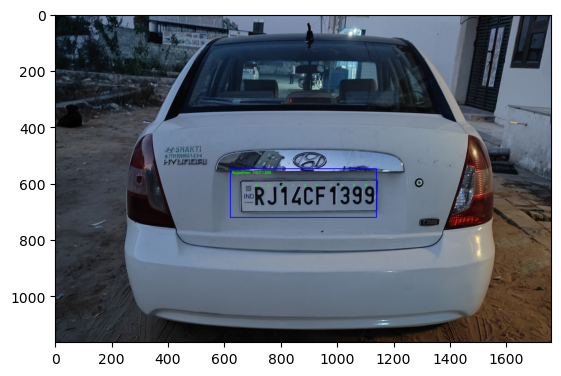

Processing CarPlate5.jpg...
License Plate: 
License Plate: 
License Plate: T1KZZJI1WZ4CPG1CZZ8C1
License Plate: 
License Plate: T


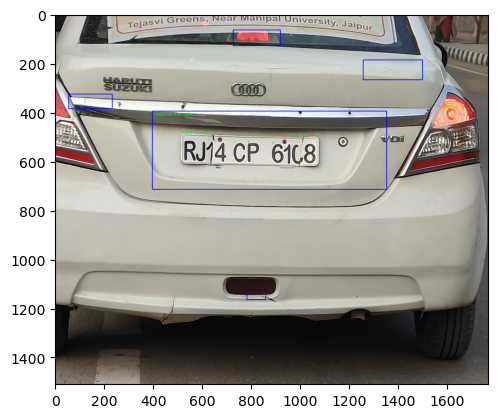

Processing CarPlate16.jpg...
License Plate: J14NC9698


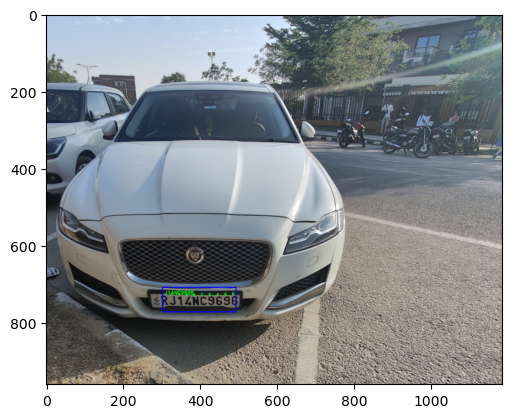

Processing CarPlate27.jpg...
License Plate: 
License Plate: QJ
License Plate: 3KA38M1G74
License Plate: X3M


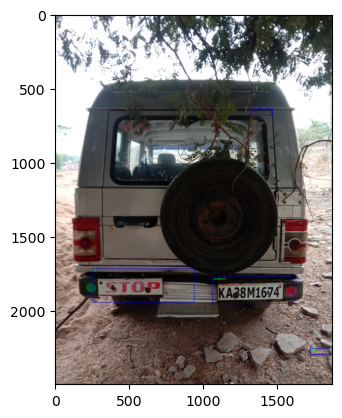

Processing CarPlate28.jpg...
License Plate: EE1KNMD1
License Plate: PIT
License Plate: 
License Plate: DO31C4945


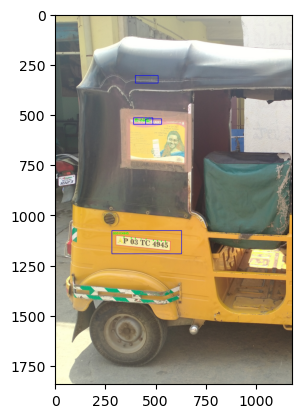

Processing CarPlate26.jpg...
License Plate: 
License Plate: 
License Plate: K4E1Z1Z23L45471


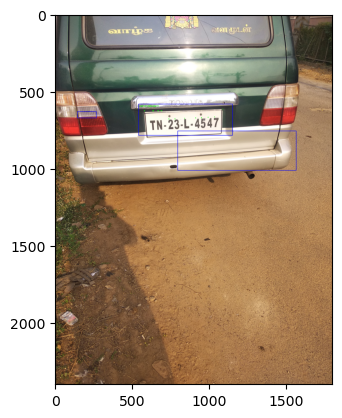

Processing CarPlate19.jpg...
License Plate: 7
License Plate: I
License Plate: Rajasthan 14CN5913J


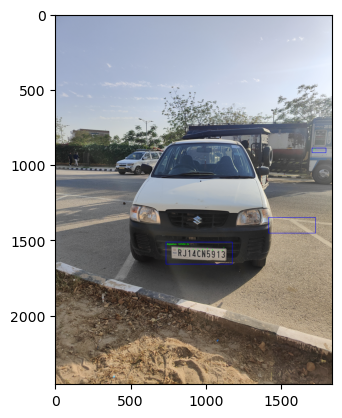

Processing CarPlate11.jpg...
License Plate: Maharashtra 20EJO364


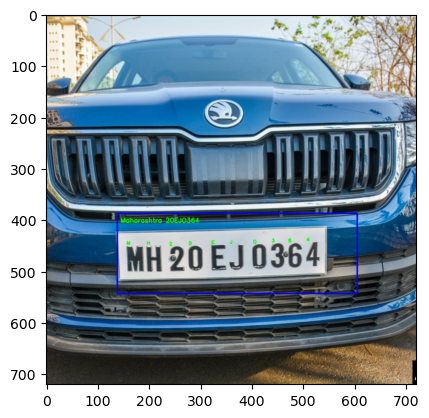

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os


model_path = "/home/pranav/ml/char_recog3.keras"
model = tf.keras.models.load_model(model_path, custom_objects={'F1Score': F1Score})

#define index_to_char mapping
index_to_char = {i: str(i) if i < 10 else chr(ord('A') + i - 10) for i in range(36)}

#define state code to state name mapping
state_codes = {
    'UP': 'Uttar Pradesh',
    'RJ': 'Rajasthan',
    'JH': 'Jharkhand',
    'MP': 'Madhya Pradesh',
    'DL': 'Delhi',
    'HR': 'Haryana',
    'PB': 'Punjab',
    'TN': 'Tamil Nadu',
    'KA': 'Karnataka',
    'MH': 'Maharashtra',
}


def ShowImage(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


def resize(img, scaleInPercent):
    width = int(img.shape[1] * scaleInPercent / 100)
    height = int(img.shape[0] * scaleInPercent / 100)
    dim = (width, height)
    return cv.resize(img, dim, interpolation=cv.INTER_AREA)

#dynamic parameter adjustment
def getAdaptiveParameters(img):
    #with the help of slicing we are getting the height and width of the img
    height, width = img.shape[:2]
    ###################################################################################################################################################################
    '''
    This dictionary stores the parameters which are used for the detection of the license plate
    scale_factor -> used to compare the resolution of the img , if the height of the img is  greater than 1k(high resolution img) then we use scale factor accordingly
    min_neighbors -> specicy how many neighbors each candidate rectangle should have to retain it if the  height of the img greater than 1k then min_neigbors 5 
    block_size -> specify the size of the pixel neighborhood to calculate the threshold value max(11, int(width*0.02))->returns the max value of 11
    why (width * 0.02)? to avoid small blocks 
    aspect_ratio_range -> range of the aspect ratio of the bounding box(it is used to filter the bounding boxes)
    area_threshold -> threshold value used to filter the bounding boxes
    '''
    ####################################################################################################################################################################
    return {
        'scale_factor': 1.05 if height > 1000 else 1.1,
        'min_neighbors': 5 if height > 1000 else 3,
        'block_size': max(11, int(width * 0.02)),
        'aspect_ratio_range': (1.8, 5.0),
        'area_threshold': max(300, (width * height) * 0.0005)
    }

###_____STEP-1 PREPROCESSING________###
#pre-processing function
def preProcessingImg(imgPath):
    #reads the image in grayscale
    imgGray = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
     #applying the clahe(contrast limiting adaptive threshold) algo to the img
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    imgGray = clahe.apply(imgGray)
     #applying adative threshold to the img for smoothing i.e. to remove noise
    #255-> max intensity value, 13-> diameter of the pixel or block size, 4-> constant value

    imgAdaptiveThresh = cv.adaptiveThreshold(imgGray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    #kernel->matrix of ones(structural element) of 3X3 size used for morphological opertions
    kernel = np.ones((3, 3), np.uint8)
    #MORPH_CLOSE->used to close small holes in the img
    imgMorph = cv.morphologyEx(imgAdaptiveThresh, cv.MORPH_CLOSE, kernel)
    '''----FOR EDGE DETECTION WE ARE USING CANNY-----'''
    edges = cv.Canny(imgAdaptiveThresh, 30, 100)
    #30->min threshold value , 100->max threhsold value
    return imgGray, imgMorph, edges

#colour classification for Indian plates
def isValidPlateColour(roi):
    hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    #this dictionarystores the colour profile of the plates
    colour_profiles = {
        'private_white': ([0, 0, 150], [180, 30, 255]),
        'commercial_yellow': ([20, 100, 100], [30, 255, 255]),
        'government_blue': ([100, 50, 50], [130, 255, 255])
    }
    #this loop iterartes theough each colour profile and checks if the roi falls in the range
    for _, (lower, upper) in colour_profiles.items():
        mask = cv.inRange(hsv, np.array(lower), np.array(upper))
        #if the sum of the mask is greater than 0.3 i.e. 30% of the mask size  then it returns true
        if np.sum(mask) > 0.3 * mask.size:
            return True
    return False

#check if a region is a potential license plate
def isPossibleLicensePlate(region, img, params):
    #coordinates of the bounding box
    minRow, minCol, maxRow, maxCol = region.bbox
    #region of interest dimesnions
    region_height = maxRow - minRow
    region_width = maxCol - minCol
    aspect_ratio = region_width / region_height
    img_height, img_width = img.shape[:2]
    return (params['aspect_ratio_range'][0] <= aspect_ratio <= params['aspect_ratio_range'][1] and region.area > params['area_threshold'])

###___STEP-2 PLATE LOCALIZATION_____###

#Haar cascade detection with dynamic parameters
def haarCascadeDetect(gray_img, params):
    #cascade -> cascade classifie obj
    #cv.data.haarcascades -> returns the path of the haarcascade xml file
    cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_russian_plate_number.xml')
    #detectMultiscale -> detcets the obj in the img
    #scaleFactor -> specifies how much the image size is reduced at each image scale
    #minNeighbors -> specifies how many neighbors each candidate rectangle should have to retain it
    return cascade.detectMultiScale(gray_img, scaleFactor=params['scale_factor'], minNeighbors=params['min_neighbors'], minSize=(30, 30))

###___STEP-3 CHARACTER SEGMENTATION___###

#Character segmentation function 
def segmentCharacters(plateImg):
    plateGray = cv.cvtColor(plateImg, cv.COLOR_BGR2GRAY)
    plateGray = cv.bilateralFilter(plateGray, 11, 17, 17)
    #applying adaptive thersholding to smooth the img
    plateThresh = cv.adaptiveThreshold(plateGray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21, 6)
    #####################################################################################################################################
    '''
    kernel is used as a structural element for morphological operations, here we are using a 3X3 sized matrix
    MORPH_ELLIPSE -> used to create elliptical shaped kernel. why? coz some characters in the plates can be elleptical in shape
    MORPH_RECT -> used to create a regular rectangular shaped kernel. why? coz some characters in the plates can be rectangular in shape
    why use a (3X3) sized matrix? to remove small black spots in the img
    cv.MorphologyEx is used here to apply morphological operation, these operations includes dilation, erosion, opening , closing
    MORPH_CLOSE -> used to close small holes in the img
    MORPH_OPEN -> used to remove small white spots in the img
    '''
    #####################################################################################################################################
    kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4, 4))
    kernel_open = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    plateThresh = cv.morphologyEx(plateThresh, cv.MORPH_CLOSE, kernel_close)
    plateThresh = cv.morphologyEx(plateThresh, cv.MORPH_OPEN, kernel_open)
    #trying to find the contours /outline of the obj in the thresholded img
    #RETR_LIST -> retrieves all the contours, but doesn't create any parent-child relationship
    #CHAIN_APPROX_SIMPLE -> compresses horizontal, vertical, diagonal segments and leaves only their end points
    contours, _ = cv.findContours(plateThresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    plate_height, plate_width = plateGray.shape
    ####################################################################################################################################
    '''
    min_width -> minimum width of the bounding box
    max(10, int(plate_height * 0.2)) -> return the ax value of 5
    why int(plate_width * 0.03)? to avoid small bounding boxes

    max_width -> maximum width of the bounding box
    why int(plate_width * 0.45)? to avoid large bouding boxes
    '''
    ###################################################################################################################################
    min_width = max(5, int(plate_width * 0.03))
    max_width = int(plate_width * 0.45)
    min_height = max(10, int(plate_height * 0.2))
    max_height = int(plate_height * 0.9)
    aspect_ratio_min = 0.15
    aspect_ratio_max = 1.5
    #filtering the contour based on the bounding box dimensions and aspect ratio
    char_bboxes = []
    for contour in contours:
        ########################################################################################################################
        '''
        this conditional block checks if the bounding box is valid or not if the bounding box is not valid then it continues to
        the next iteration, if the bounding box is valid then it appends the bounding box to char_bboxes list
        '''
        #########################################################################################################################       
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = w / float(h)
        if (w < min_width or w > max_width or
                h < min_height or h > max_height or
                aspect_ratio < aspect_ratio_min or
                aspect_ratio > aspect_ratio_max):
            continue
        char_bboxes.append((x, y, w, h))
    char_bboxes = mergeOverlappingboxes(char_bboxes)
    refined_boxes = []
    for box in char_bboxes:
        x, y, w, h = box
        avg_width = np.mean([b[2] for b in char_bboxes]) if char_bboxes else w
        if w > avg_width * 1.65:
            split_boxes = splitTouchingCharacters(plateThresh[y:y + h, x:x + w], x, y)
            refined_boxes.extend(split_boxes)
        else:
            refined_boxes.append(box)
    refined_boxes = sorted(refined_boxes, key=lambda b: b[0])
    refined_boxes = filterVerticalOutliers(refined_boxes)
    return refined_boxes

def mergeOverlappingboxes(bboxes, overlap_threshold=0.7):
    #overlap_threshold=0.7 -> if the overlap area of the two boxes is greater than the threshold value then it is merged
    #this list will store the coordinates of the merged bounding boxes
    merged = []
    #sorting the bounidng boxes on the basis of x coordinates 
    for box in sorted(bboxes, key=lambda b: b[0]):
        x, y, w, h = box
        #initially found is set to false coz we have not found any overlapping bunding boxes
        found = False
        #this loop iterates through each boundig box in the merged list
        #enumerate(merged) -> returns the index and bounding box
        for i, mbox in enumerate(merged):
            #coordinates of the merged bounding box
            mx, my, mw, mh = mbox
            #dx -> width of the overlapping area, dy-> height of the overlapping area
            dx = min(x + w, mx + mw) - max(x, mx)
            dy = min(y + h, my + mh) - max(y, my)
            if dx > 0 and dy > 0:#checking of the overlapping area exists
                overlap_area = dx * dy
                min_area = min(w * h, mw * mh)
                if overlap_area / min_area > overlap_threshold:
                    nx = min(x, mx)
                    ny = min(y, my)
                    nw = max(x + w, mx + mw) - nx
                    nh = max(y + h, my + mh) - ny
                    #replaces the merged bounding box with the new merged bounding box
                    merged[i] = (nx, ny, nw, nh)
                    found = True
                    break
        if not found:
            merged.append(box)
    return merged

def splitTouchingCharacters(char_region, orig_x, orig_y):
    #char_rgeion -> regions of the character, orig_x,orig_y-> coordinate sof the bounding box
    #verticle_projection is the sum of the pixel values in the verticle direction
    vertical_projection = np.sum(char_region, axis=0)
    #this threhsold value is used to to split characters, if the pixel values is less than the threshold value then the characters are split
    threshold = 0.2 * np.max(vertical_projection)
    gaps = np.where(vertical_projection < threshold)[0]
    split_boxes = []
    if len(gaps) > 0:
         #prev-> this variable is used to store the previous gap value on the basis of its we split the chars
        prev = 0
        for gap in gaps:
             #if the gap-prev > 2 we split the characters . why 2? to avoid small bounding boxes
            if gap - prev > 2:
                split_boxes.append((orig_x + prev, orig_y, gap - prev, char_region.shape[0]))
                #this statement updates the prev value
                prev = gap
        split_boxes.append((orig_x + prev, orig_y, char_region.shape[1] - prev, char_region.shape[0]))
    else:
        split_boxes.append((orig_x, orig_y, char_region.shape[1], char_region.shape[0]))
    valid_boxes = []
    for box in split_boxes:
        x, y, w, h = box
        if w > 5 and h > 10:
            valid_boxes.append(box)
    return valid_boxes

########################################################################################################################
'''
this function is  used to filter the verticle (outliers-> data pts that differ significantly from other observations)
in simple terms bounding boxes which are not in the same line
median_y -> median of the y coordinates of the bounding boxes(here median is used to avoid outliers)
median is a measure of central tendency which is less affected by the outliers
median_h -> median of the height of the bounding boxes
box[1] -> y coordinate of the bounding box, box[3]-> height of the bounding box
'''
##########################################################################################################################
def filterVerticalOutliers(bboxes, threshold=0.7):
    if not bboxes:
        return []
    median_y = np.median([b[1] for b in bboxes])
    median_h = np.median([b[3] for b in bboxes])
    filtered = []
    #this loop iterates through each bounding box in bboxes list
    for box in bboxes:
        y, h = box[1], box[3]
        if (abs(y - median_y) < median_h * 0.5 and
                abs(h - median_h) < median_h * threshold):
            filtered.append(box)
    return filtered

###___STEP-4 CHARACTER RECOGNITION___###

#function to preprocess character images for inference
def preprocessChar(char_img):
    #convert to grayscale
    char_gray = cv.cvtColor(char_img, cv.COLOR_BGR2GRAY)
    #apply binary thresholding (inverted: white characters on black background)
    _, char_thresh = cv.threshold(char_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    #resize to 28x28
    char_resized = cv.resize(char_thresh, (28, 28), interpolation=cv.INTER_AREA)
    #convert to 3 channels TO replicate grayscale to RGB
    char_rgb = cv.cvtColor(char_resized, cv.COLOR_GRAY2RGB)
    #normalize pixel values
    char_normalized = char_rgb.astype('float32') / 255.0
    return char_normalized

#function to recognize characters in a license plate
def recognizeCharacters(roi):
    char_bboxes = segmentCharacters(roi)
    characters = []
    for idx, (cx, cy, cw, ch) in enumerate(char_bboxes):
        char_img = roi[cy:cy+ch, cx:cx+cw]
        if char_img.size == 0:
            continue
        char_input = preprocessChar(char_img)
        char_input = np.expand_dims(char_input, axis=0)
        predictions = model.predict(char_input, verbose=0)
        predicted_idx = np.argmax(predictions, axis=1)[0]
        predicted_char = index_to_char.get(predicted_idx, '?')
        characters.append(predicted_char)
        cv.putText(roi, predicted_char, (cx, cy-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    #process detected characters
    plate_str = ''.join(characters)
    if len(plate_str) >= 2:
        state_code = plate_str[:2]
        state_name = state_codes.get(state_code, None)
        if state_name:
            formatted_plate = f"{state_name} {plate_str[2:]}"
        else:
            formatted_plate = plate_str
    else:
        formatted_plate = plate_str

    #add full plate text to the image
    cv.putText(roi, formatted_plate, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    print(f"License Plate: {formatted_plate}")
    return formatted_plate

#license plate localization function with character segmentation
def plateLocalization(imgPath):
    img = cv.imread(imgPath)
    params = getAdaptiveParameters(img)
    gray, thresh, edges = preProcessingImg(imgPath)
    detected_plates = []

    #Haar Cascade Detection
    plates_haar = haarCascadeDetect(gray, params)
    for (x, y, w, h) in plates_haar:
        roi = img[y:y + h, x:x + w]
        if isValidPlateColour(roi):
            detected_plates.append((x, y, w, h))
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
            
            recognizeCharacters(roi)

    #display results
    ShowImage(resize(img, 60))

for img_file in image_files:
    img_path = os.path.join(sample_img_dir, img_file)
    print(f"Processing {img_file}...")
    plateLocalization(img_path)